# G27
Dave Brunner

In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from torch.nn import Sequential, Flatten, Linear, Module, Conv2d, MaxPool2d, CrossEntropyLoss, Tanh, ReLU, Softmax, \
    BatchNorm2d, Dropout, BatchNorm1d
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [3]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())
print(f'Training data: {len(training_data)}')
print(f'Test data: {len(test_data)}')
print(f'Test data shape: {test_data.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Training data: 50000
Test data: 10000
Test data shape: (10000, 32, 32, 3)


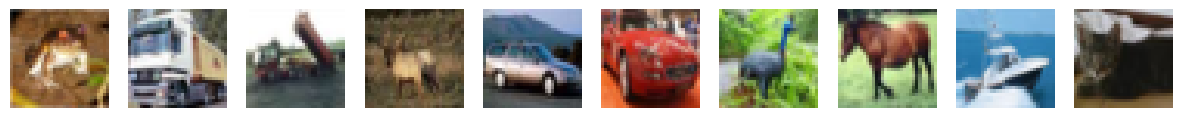

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    # axs[i].set_title(training_data.classes[i] + f': {i}')
    axs[i].imshow(training_data.data[i], cmap='gray')
    axs[i].axis('off')

In [5]:
class EmptyForward(Module):
    @staticmethod
    def forward(x):
        return x

class PrintForward(Module):
    @staticmethod
    def forward(x):
        print(x.shape)
        return x

class CNN(Module):
    def __init__(self, activation_function=ReLU(), batch_normalization=False, dropout_rate=0):
        super(CNN, self).__init__()
        self.model = Sequential(
            Conv2d(3, 32, 3, 1),  # 32 * 30 * 30
            BatchNorm2d(32) if batch_normalization else EmptyForward(),
            activation_function,

            Conv2d(32, 64, 3, 1),  # 64 * 28 * 28
            BatchNorm2d(64) if batch_normalization else EmptyForward(),
            activation_function,

            MaxPool2d(2, 2),  # 64 * 14 * 14

            Conv2d(64, 128, 3, 1),  # 128 * 12 * 12
            BatchNorm2d(128) if batch_normalization else EmptyForward(),
            activation_function,

            Conv2d(128, 128, 3, 1),  # 128 * 10 * 10
            BatchNorm2d(128) if batch_normalization else EmptyForward(),
            activation_function,

            Flatten(),
            Dropout(dropout_rate),
            Linear(128 * 10 * 10, 128),
            BatchNorm1d(128) if batch_normalization else EmptyForward(),
            activation_function,

            Dropout(dropout_rate),
            Linear(128, 64),
            BatchNorm1d(64) if batch_normalization else EmptyForward(),
            activation_function,

            Dropout(dropout_rate),
            Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

In [6]:
model = CNN()

In [7]:
summary(model, (3, 32, 32))
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
      EmptyForward-2           [-1, 32, 30, 30]               0
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
      EmptyForward-5           [-1, 64, 28, 28]               0
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 12, 12]          73,856
      EmptyForward-9          [-1, 128, 12, 12]               0
             ReLU-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 128, 10, 10]         147,584
     EmptyForward-12          [-1, 128, 10, 10]               0
             ReLU-13          [-1, 128, 10, 10]               0
          Flatten-14                [-1

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): EmptyForward()
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): EmptyForward()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): EmptyForward()
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): EmptyForward()
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=12800, out_features=128, bias=True)
    (16): EmptyForward()
    (17): ReLU()
    (18): Dropout(p=0, inplace=False)
    (19): Linear(in_features=128, out_features=64, bias=True)
    (20): EmptyForward()
    (21): ReLU()
    (22): Dropout(p=0, inplace=False)
    (23): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
def train_plot_model(model, n_epochs=5):
    n_batch = 1024
    loss_fn = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loader = DataLoader(training_data, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(n_epochs):
        local_train_loss, local_train_acc, batch_count = 0, 0, 0
        # enumerate mini batches
        print(f'Epoch: {epoch + 1}')
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x, train_y = train_x.to(device), train_y.to(device)
            optimizer.zero_grad()
            yhat = model(train_x)
            loss = loss_fn(yhat, train_y)
            loss.backward()
            optimizer.step()

            local_train_loss += loss.item()
            local_train_acc += ((yhat.argmax(1) == train_y).float().mean()).to('cpu')
            batch_count += 1

        with torch.no_grad():
            train_loss.append(local_train_loss / batch_count)
            train_acc.append(local_train_acc / batch_count)
            print(f'Training   -> Loss: {train_loss[-1]:.3f}, Accuracy: {train_acc[-1]:.3f}')
            for test_x, test_y in test_loader:
                test_x, test_y = test_x.to(device), test_y.to(device)
                yhat = model(test_x)
                val_loss.append(loss_fn(yhat, test_y).item())
                val_acc.append(((yhat.argmax(1) == test_y).float().mean()).to('cpu'))
                print(f'Validation -> Loss: {val_loss[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}')
        print('------------------------------------------------')
    plt.figure(1, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    return {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': val_loss,
        'test_acc': val_acc
    }

In [9]:
result_dict = {}

Regular model
Epoch: 1
Training   -> Loss: 2.482, Accuracy: 0.193
Validation -> Loss: 1.946, Accuracy: 0.276
------------------------------------------------
Epoch: 2
Training   -> Loss: 1.904, Accuracy: 0.293
Validation -> Loss: 1.856, Accuracy: 0.313
------------------------------------------------
Epoch: 3
Training   -> Loss: 1.680, Accuracy: 0.378
Validation -> Loss: 1.561, Accuracy: 0.427
------------------------------------------------
Epoch: 4
Training   -> Loss: 1.559, Accuracy: 0.426
Validation -> Loss: 1.499, Accuracy: 0.449
------------------------------------------------
Epoch: 5
Training   -> Loss: 1.454, Accuracy: 0.467
Validation -> Loss: 1.423, Accuracy: 0.477
------------------------------------------------
Epoch: 6
Training   -> Loss: 1.397, Accuracy: 0.490
Validation -> Loss: 1.354, Accuracy: 0.507
------------------------------------------------
Epoch: 7
Training   -> Loss: 1.321, Accuracy: 0.521
Validation -> Loss: 1.342, Accuracy: 0.519
---------------------------

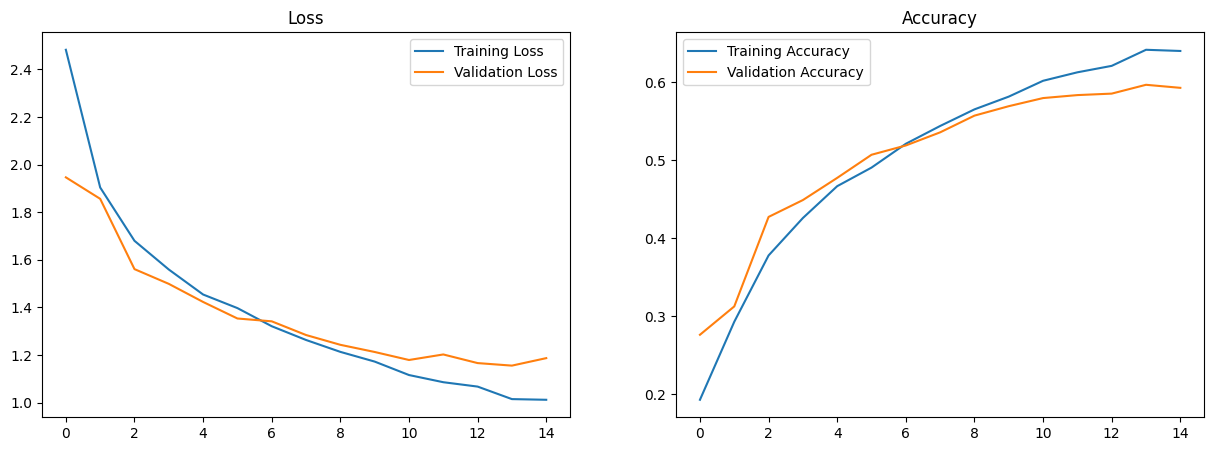

In [10]:
print('Regular model')
model = CNN().to(device)
result_dict['Regular'] = train_plot_model(model, n_epochs=15)

Tanh model
Epoch: 1
Training   -> Loss: 2.329, Accuracy: 0.100
Validation -> Loss: 2.309, Accuracy: 0.100
------------------------------------------------
Epoch: 2
Training   -> Loss: 2.313, Accuracy: 0.101
Validation -> Loss: 2.313, Accuracy: 0.100
------------------------------------------------
Epoch: 3
Training   -> Loss: 2.310, Accuracy: 0.101
Validation -> Loss: 2.306, Accuracy: 0.100
------------------------------------------------
Epoch: 4
Training   -> Loss: 2.310, Accuracy: 0.100
Validation -> Loss: 2.309, Accuracy: 0.100
------------------------------------------------
Epoch: 5
Training   -> Loss: 2.311, Accuracy: 0.098
Validation -> Loss: 2.312, Accuracy: 0.100
------------------------------------------------
Epoch: 6
Training   -> Loss: 2.313, Accuracy: 0.101
Validation -> Loss: 2.321, Accuracy: 0.100
------------------------------------------------
Epoch: 7
Training   -> Loss: 2.313, Accuracy: 0.101
Validation -> Loss: 2.308, Accuracy: 0.100
------------------------------

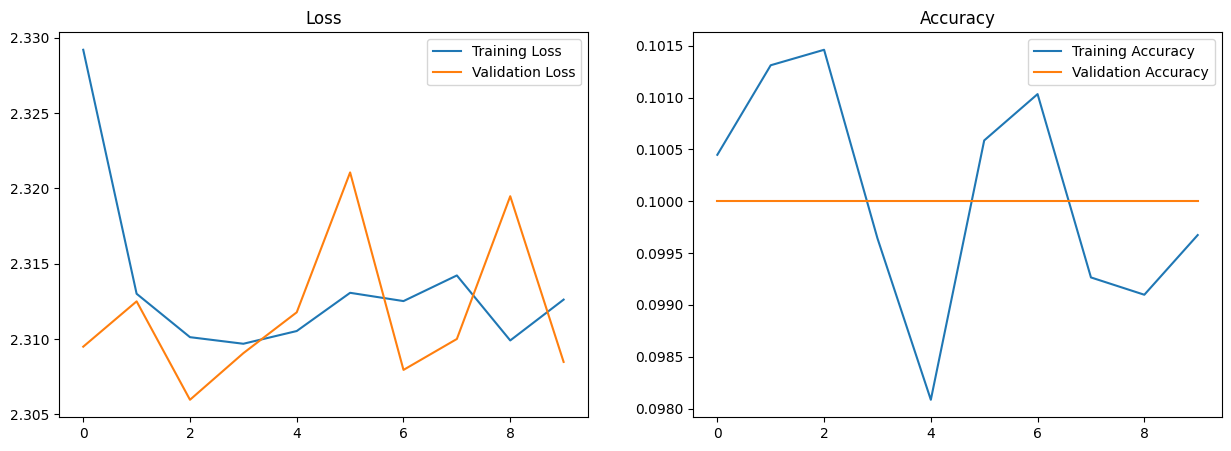

In [11]:
print('Tanh model')
model = CNN(activation_function=Tanh())
model.to(device)
result_dict['Tanh'] = train_plot_model(model, n_epochs=10)

Batchnorm. ReLU model
Epoch: 1
Training   -> Loss: 1.642, Accuracy: 0.394
Validation -> Loss: 1.342, Accuracy: 0.507
------------------------------------------------
Epoch: 2
Training   -> Loss: 1.184, Accuracy: 0.573
Validation -> Loss: 1.025, Accuracy: 0.636
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.896, Accuracy: 0.680
Validation -> Loss: 0.819, Accuracy: 0.709
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.727, Accuracy: 0.744
Validation -> Loss: 0.731, Accuracy: 0.741
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.598, Accuracy: 0.789
Validation -> Loss: 0.692, Accuracy: 0.758
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.483, Accuracy: 0.830
Validation -> Loss: 0.701, Accuracy: 0.762
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.395, Accuracy: 0.862
Validation -> Loss: 0.683, Accuracy: 0.777
-------------------

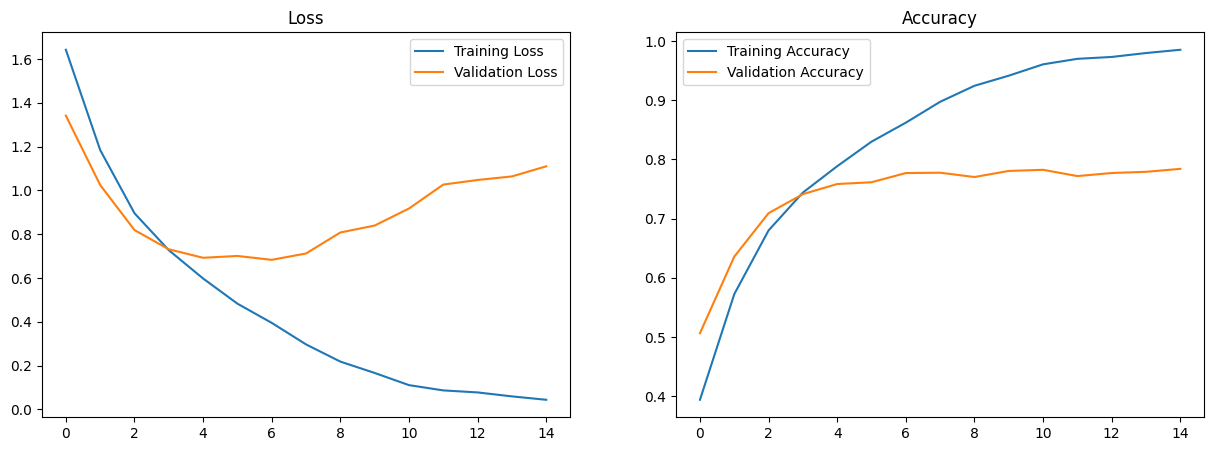

In [12]:
print('Batchnorm. ReLU model')
model = CNN(batch_normalization=True).to(device)
result_dict['Batchnorm. ReLU'] = train_plot_model(model, n_epochs=15)

Batchnorm. Tanh model
Epoch: 1
Training   -> Loss: 1.783, Accuracy: 0.351
Validation -> Loss: 1.534, Accuracy: 0.439
------------------------------------------------
Epoch: 2
Training   -> Loss: 1.429, Accuracy: 0.479
Validation -> Loss: 1.327, Accuracy: 0.523
------------------------------------------------
Epoch: 3
Training   -> Loss: 1.253, Accuracy: 0.549
Validation -> Loss: 1.214, Accuracy: 0.564
------------------------------------------------
Epoch: 4
Training   -> Loss: 1.118, Accuracy: 0.600
Validation -> Loss: 1.071, Accuracy: 0.623
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.981, Accuracy: 0.653
Validation -> Loss: 0.966, Accuracy: 0.660
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.872, Accuracy: 0.692
Validation -> Loss: 0.890, Accuracy: 0.683
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.782, Accuracy: 0.727
Validation -> Loss: 0.846, Accuracy: 0.704
-------------------

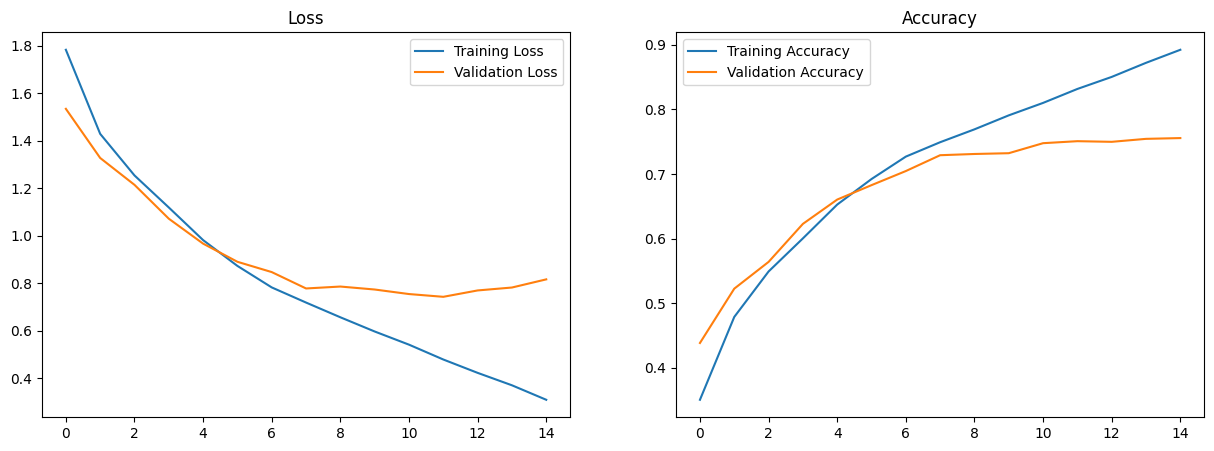

In [13]:
print('Batchnorm. Tanh model')
model = CNN(activation_function=Tanh(), batch_normalization=True).to(device)
result_dict['Batchnorm. Tanh'] = train_plot_model(model, n_epochs=15)

Dropout ReLU model
Epoch: 1
Training   -> Loss: 2.615, Accuracy: 0.166
Validation -> Loss: 2.038, Accuracy: 0.242
------------------------------------------------
Epoch: 2
Training   -> Loss: 1.905, Accuracy: 0.290
Validation -> Loss: 1.756, Accuracy: 0.344
------------------------------------------------
Epoch: 3
Training   -> Loss: 1.725, Accuracy: 0.356
Validation -> Loss: 1.729, Accuracy: 0.370
------------------------------------------------
Epoch: 4
Training   -> Loss: 1.623, Accuracy: 0.400
Validation -> Loss: 1.580, Accuracy: 0.421
------------------------------------------------
Epoch: 5
Training   -> Loss: 1.534, Accuracy: 0.441
Validation -> Loss: 1.523, Accuracy: 0.454
------------------------------------------------
Epoch: 6
Training   -> Loss: 1.456, Accuracy: 0.473
Validation -> Loss: 1.503, Accuracy: 0.459
------------------------------------------------
Epoch: 7
Training   -> Loss: 1.400, Accuracy: 0.497
Validation -> Loss: 1.406, Accuracy: 0.496
----------------------

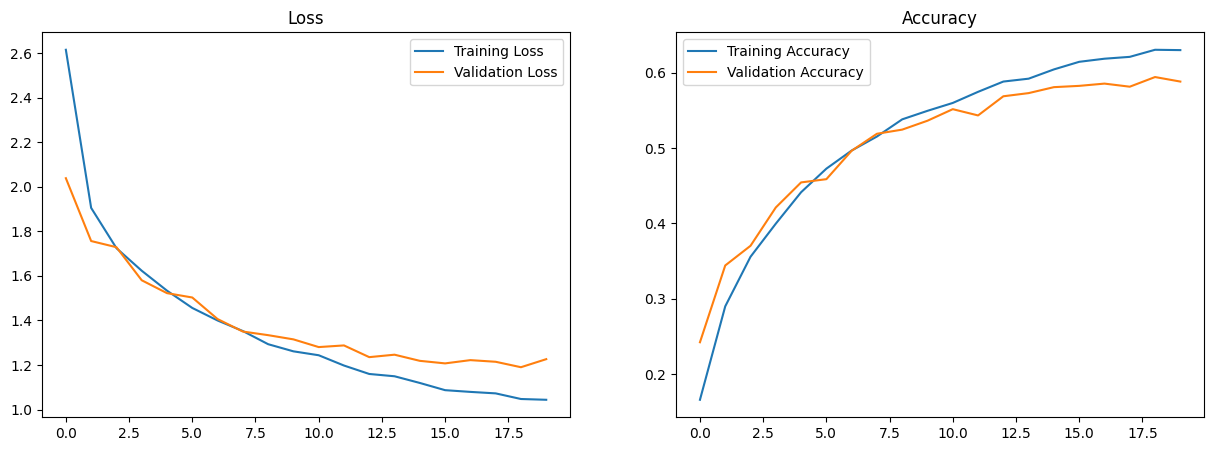

In [14]:
print('Dropout ReLU model')
model = CNN(dropout_rate=0.2).to(device)
result_dict['Dropout ReLU'] = train_plot_model(model, n_epochs=25)

With dropout enabled, the model does not do better than the regular model.
Also more epochs do not help to improve the accuracy.

Dropout & Batchnorm. ReLU model
Epoch: 1
Training   -> Loss: 1.675, Accuracy: 0.375
Validation -> Loss: 1.377, Accuracy: 0.495
------------------------------------------------
Epoch: 2
Training   -> Loss: 1.234, Accuracy: 0.554
Validation -> Loss: 1.131, Accuracy: 0.596
------------------------------------------------
Epoch: 3
Training   -> Loss: 1.014, Accuracy: 0.638
Validation -> Loss: 0.949, Accuracy: 0.666
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.843, Accuracy: 0.704
Validation -> Loss: 0.845, Accuracy: 0.704
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.723, Accuracy: 0.747
Validation -> Loss: 0.781, Accuracy: 0.729
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.641, Accuracy: 0.776
Validation -> Loss: 0.729, Accuracy: 0.752
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.560, Accuracy: 0.806
Validation -> Loss: 0.735, Accuracy: 0.753
---------

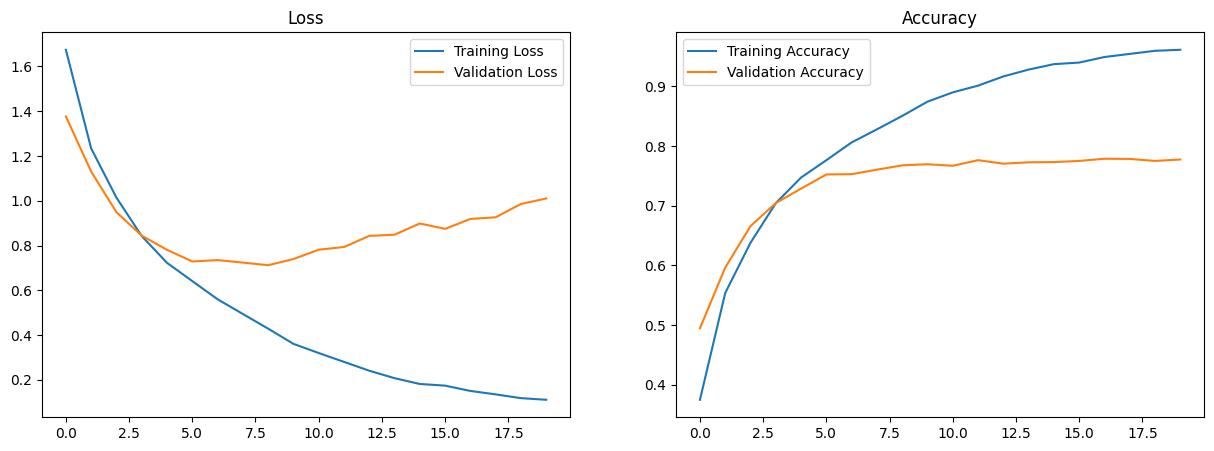

In [15]:
print('Dropout & Batchnorm. ReLU model')
model = CNN(dropout_rate=0.2, batch_normalization=True).to(device)
result_dict['Dropout & batchnorm. ReLU'] = train_plot_model(model, n_epochs=20)

With droput and batch normalization enabled, the performance is better.
The accuracy increases to around 0.77 after 20 epochs.
More epochs do not help to improve the accuracy and the model starts to overfit.

# Conclusion, summary and plots

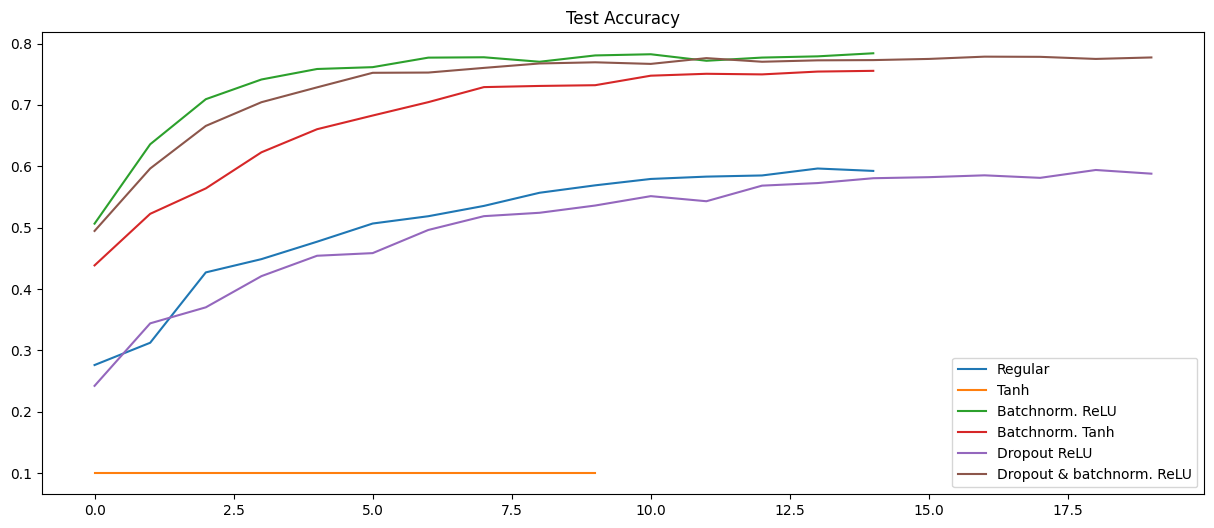

In [17]:
plt.figure(1, figsize=(15, 6))
for key, value in result_dict.items():
    plt.plot(value['test_acc'], label=f'{key}')
plt.title('Test Accuracy')
plt.legend()
plt.show()

I am surprised how much better the model with batch normalization performs compared to the regular model.
The dropout should help to generalize the model better, but I dont see any significant change in the accuracy curve compared to without dropout.
The model with the tanh activation function is not able to learn anything. The accuracy is stuck at the statistical average of 0.1. If I would normalize the input data, the tanh model would be able to learn, as we see when looking at the model with batch normalization and tanh activation function.

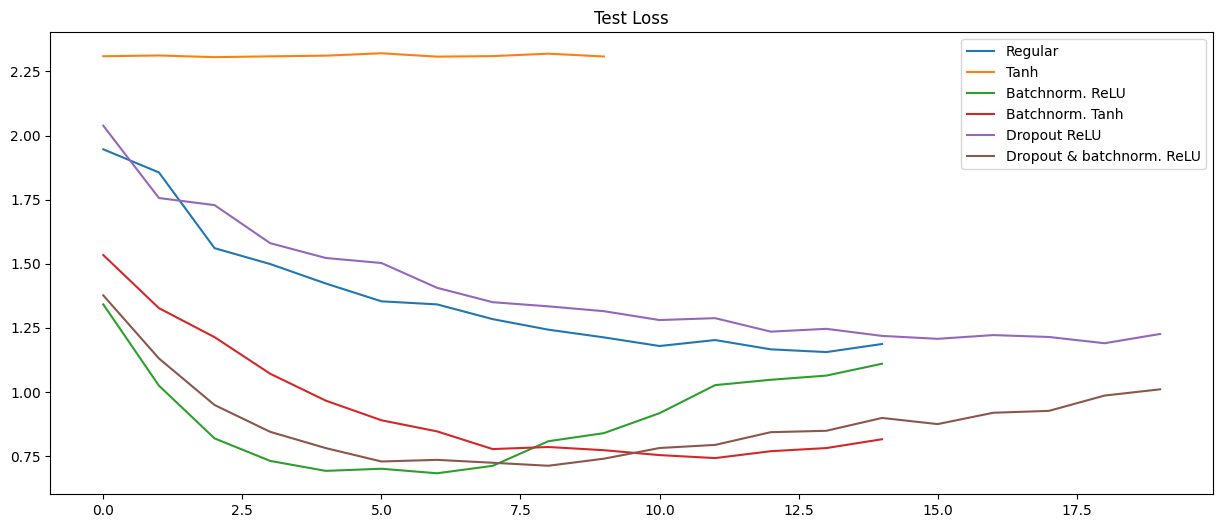

In [18]:
plt.figure(1, figsize=(15, 6))
for key, value in result_dict.items():
    plt.plot(value['test_loss'], label=f'{key}')
plt.title('Test Loss')
plt.legend()
plt.show()